In [8]:
import pandas as pd
import numpy as np

In [6]:
data = pd.read_csv('ab_data.csv', sep=';')
data = data.rename(columns={'key_resp.keys': 'key', 'key_resp.rt': 'rt'})
data

,img,cond,presence,key,rt,corr
0,a_neut18.jpg,neutral,no,right,"4,1494",0
1,b_neut1.jpg,neutral,yes,right,"3,5734",1
2,b_neut5.jpg,neutral,yes,right,"2,3108",1
3,b_neut7.jpg,neutral,yes,right,"2,4918",1
4,a_neut22.jpg,neutral,no,left,"6,7813",1
...,...,...,...,...,...,...
103,a_neg32.jpg,negative,yes,right,"1,3906",1
104,b_neg9.BMP,negative,yes,right,"1,0261",1
105,a_neg36.jpg,negative,yes,right,"0,9499",1
106,b_neg31.jpg,negative,no,right,"0,9671",0


Counting hits and False Alarms (FA)

In [12]:
# Counting hits
hit_conditions = [
    (data['key'] == 'right') & (data['corr'] == 1),
    (data['key'] != 'right') | (data['corr'] != 1),
]
data['hit'] = np.select(hit_conditions, [1, 0])

# Counting FAs
FA_conditions = [
    (data['key'] == 'right') & (data['corr'] == 0),
    (data['key'] != 'right') | (data['corr'] != 0),
]
data['FA'] = np.select(FA_conditions, [1, 0])
data

,img,cond,presence,key,rt,corr,hit,FA
0,a_neut18.jpg,neutral,no,right,"4,1494",0,0,1
1,b_neut1.jpg,neutral,yes,right,"3,5734",1,1,0
2,b_neut5.jpg,neutral,yes,right,"2,3108",1,1,0
3,b_neut7.jpg,neutral,yes,right,"2,4918",1,1,0
4,a_neut22.jpg,neutral,no,left,"6,7813",1,0,0
...,...,...,...,...,...,...,...,...
103,a_neg32.jpg,negative,yes,right,"1,3906",1,1,0
104,b_neg9.BMP,negative,yes,right,"1,0261",1,1,0
105,a_neg36.jpg,negative,yes,right,"0,9499",1,1,0
106,b_neg31.jpg,negative,no,right,"0,9671",0,0,1


In [15]:
data['rt']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img       108 non-null    object
 1   cond      108 non-null    object
 2   presence  108 non-null    object
 3   key       108 non-null    object
 4   rt        108 non-null    object
 5   corr      108 non-null    int64 
 6   hit       108 non-null    int32 
 7   FA        108 non-null    int32 
dtypes: int32(2), int64(1), object(5)
memory usage: 6.0+ KB


In [ ]:
# Change table "rt" type to float
data['rt'] = data['rt'].apply(lambda x: ".".join(x.split(',')))
data['rt'] = data['rt'].astype(float)

Counting confirmations and rejections

In [29]:
grouped = data.groupby(["cond", "presence"]).agg({
  "corr": "mean",
}).reset_index()
grouped

,cond,presence,corr
0,negative,no,0.555556
1,negative,yes,0.777778
2,neutral,no,0.944444
3,neutral,yes,0.611111
4,positive,no,0.777778
5,positive,yes,0.833333


<Axes: title={'center': 'Rejections in %'}, xlabel='cond'>

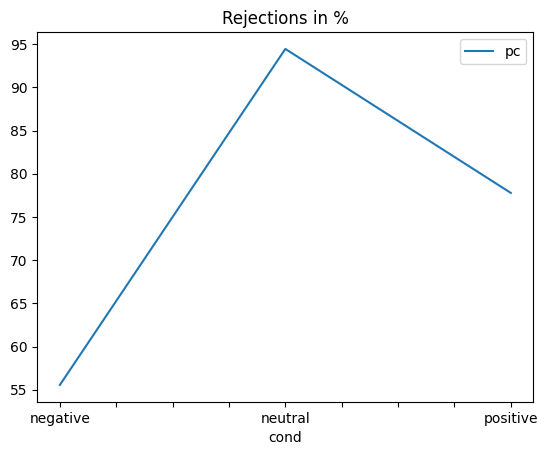

In [69]:
import matplotlib

grouped['pc'] = grouped['corr'] * 100

grouped[grouped['presence'] == 'no'].plot(title='Rejections in %', x="cond", y=["pc"])

<Axes: title={'center': 'Confirmations in %'}, xlabel='cond'>

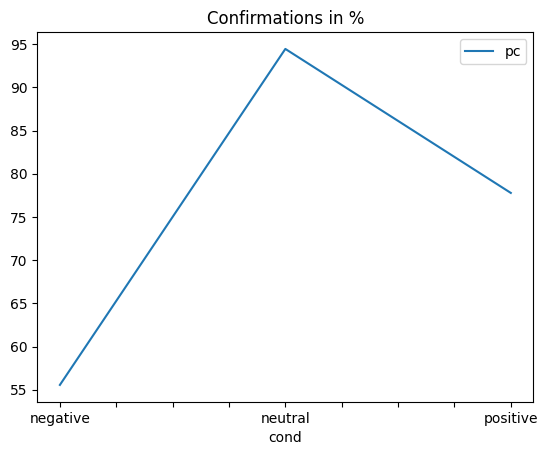

In [68]:
grouped[grouped['presence'] == 'no'].plot(title='Confirmations in %', x="cond", y=["pc"])

Signal processing theory

In [31]:
spt = data.groupby(["cond", "presence"]).agg({
  "hit": "mean",
  "FA": "mean"
}).reset_index()
spt

,cond,presence,hit,FA
0,negative,no,0.000000,0.444444
1,negative,yes,0.777778,0.000000
2,neutral,no,0.000000,0.055556
3,neutral,yes,0.611111,0.000000
4,positive,no,0.000000,0.222222
5,positive,yes,0.833333,0.000000


In [35]:
from scipy.stats import norm

# Counting probability of hits and FAs
spt['p'] = spt['hit'] + spt['FA']

# Counting z-value
spt['z'] = norm.ppf(spt['p'])

spt

,cond,presence,hit,FA,p,z
0,negative,no,0.000000,0.444444,0.444444,-0.139710
1,negative,yes,0.777778,0.000000,0.777778,0.764710
2,neutral,no,0.000000,0.055556,0.055556,-1.593219
3,neutral,yes,0.611111,0.000000,0.611111,0.282216
4,positive,no,0.000000,0.222222,0.222222,-0.764710
5,positive,yes,0.833333,0.000000,0.833333,0.967422


Counting sensitivity and criterion

In [53]:
for cond in spt['cond'].unique():
    print(cond)
    z_hit = (spt[(spt['cond'] == cond) & (spt['presence'] == 'yes')]['z'].reset_index())['z'][0]
    z_FA = (spt[(spt['cond'] == cond) & (spt['presence'] == 'no')]['z'].reset_index())['z'][0]
    print("Sensitivity:", z_hit - z_FA)
    print("Criterion:", -0.5 *(z_hit - z_FA))


negative
Sensitivity: 0.9044199726682493
Criterion: -0.4522099863341246
neutral
Sensitivity: 1.8754349650855588
Criterion: -0.9377174825427794
positive
Sensitivity: 1.7321312398880881
Criterion: -0.8660656199440441


Repeating all steps but for races

In [71]:
data['race'] = data['img'].apply(lambda x: x.split('_')[0])
data

,img,cond,presence,key,rt,corr,hit,FA,race
0,a_neut18.jpg,neutral,no,right,4.1494,0,0,1,a
1,b_neut1.jpg,neutral,yes,right,3.5734,1,1,0,b
2,b_neut5.jpg,neutral,yes,right,2.3108,1,1,0,b
3,b_neut7.jpg,neutral,yes,right,2.4918,1,1,0,b
4,a_neut22.jpg,neutral,no,left,6.7813,1,0,0,a
...,...,...,...,...,...,...,...,...,...
103,a_neg32.jpg,negative,yes,right,1.3906,1,1,0,a
104,b_neg9.BMP,negative,yes,right,1.0261,1,1,0,b
105,a_neg36.jpg,negative,yes,right,0.9499,1,1,0,a
106,b_neg31.jpg,negative,no,right,0.9671,0,0,1,b


In [72]:
grouped_by_race = data.groupby(["race", "presence"]).agg({
  "corr": "mean",
}).reset_index()
grouped_by_race

,race,presence,corr
0,a,no,0.611111
1,a,yes,0.666667
2,b,no,0.833333
3,b,yes,0.833333
4,w,no,0.833333
5,w,yes,0.722222


<Axes: title={'center': 'Rejections in %'}, xlabel='race'>

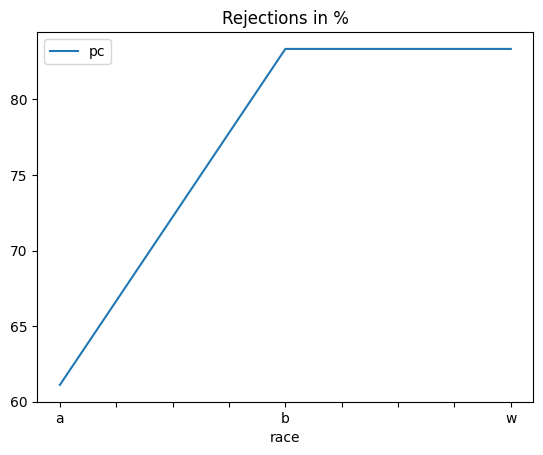

In [73]:
grouped_by_race['pc'] = grouped_by_race['corr'] * 100

grouped_by_race[grouped_by_race['presence'] == 'no'].plot(title='Rejections in %', x="race", y=["pc"])

<Axes: title={'center': 'Confirmations in %'}, xlabel='race'>

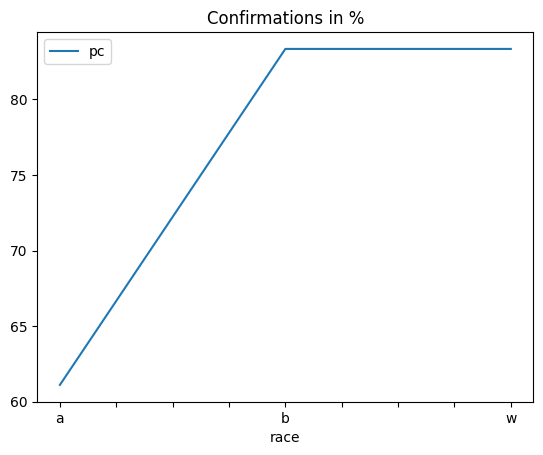

In [74]:
grouped_by_race[grouped_by_race['presence'] == 'no'].plot(title='Confirmations in %', x="race", y=["pc"])

In [79]:
spt_race = data.groupby(["race", "presence"]).agg({
  "hit": "mean",
  "FA": "mean"
}).reset_index()
spt_race

,race,presence,hit,FA
0,a,no,0.000000,0.388889
1,a,yes,0.666667,0.000000
2,b,no,0.000000,0.166667
3,b,yes,0.833333,0.000000
4,w,no,0.000000,0.166667
5,w,yes,0.722222,0.000000


In [80]:
# Counting probability of hits and FAs
spt_race['p'] = spt_race['hit'] + spt_race['FA']

# Counting z-value
spt_race['z'] = norm.ppf(spt_race['p'])

spt_race

,race,presence,hit,FA,p,z
0,a,no,0.000000,0.388889,0.388889,-0.282216
1,a,yes,0.666667,0.000000,0.666667,0.430727
2,b,no,0.000000,0.166667,0.166667,-0.967422
3,b,yes,0.833333,0.000000,0.833333,0.967422
4,w,no,0.000000,0.166667,0.166667,-0.967422
5,w,yes,0.722222,0.000000,0.722222,0.589456


In [81]:
for race in spt_race['race'].unique():
    print(race)
    z_hit = (spt_race[(spt_race['race'] == race) & (spt_race['presence'] == 'yes')]['z'].reset_index())['z'][0]
    z_FA = (spt_race[(spt_race['race'] == race) & (spt_race['presence'] == 'no')]['z'].reset_index())['z'][0]
    print("Sensitivity:", z_hit - z_FA)
    print("Criterion:", -0.5 *(z_hit - z_FA))

a
Sensitivity: 0.7129434463579656
Criterion: -0.3564717231789828
b
Sensitivity: 1.934843132203402
Criterion: -0.967421566101701
w
Sensitivity: 1.5568773639514792
Criterion: -0.7784386819757396
